# Ensemble Techniques

Ensemble techniques combine predictions from multiple models to generate a final prediction. The more models in the ensemble, the better it performs. The worst an ensemble technique can perform is equivalent to its best baseline model. Nearly every single winning Kaggle solution features these techniques

The basic premise of an ensemble technique is that combines predictions from several models to average out the idiosyncratic errors to build better overall predictions. A simple way to chose a final prediction is by using a voting system. Each model votes using their prediction, and majority wins. There are several other ways, and we can also use a model to *learn* how to best combine predictions.

Two important aspects of ensembles:
1. The lower the correlation in the prediction errors, the better
2. The more models in the ensemble, the better

For this reason, it's a good idea to use as many different models as possible (as long as the perform decently). We can formulize our ensemble as $n$ models $f_i$ averaged in ensemble $e$:

$ e(x) = 1/n*\sum{^n_{i=1}}f_i(x)$

We can include any models we want in our ensembles: decision trees, kernel-based models, linear models, non-parametric models, etc.

Using more models however comes with the trade-off of more computation time.

### Ensemble Schematic

Here is an example of an ensemble schematic. The input array $X$ is passed through 2 preprocessing pipelines, $Tr^{(i)}$, and then to a set of base learners, $f^{(i)}$. The ensemble technique combines the predictions from all the base learners into a final prediction array $P$.

![title](https://www.dataquest.io/blog/content/images/2018/01/network-1.png)


### Model Performance Evaluation

We will use the Area Under Receiver Operating Characteristic Curve (ROC-AUC) score to evaluate our models as this score trades off having high precision and high recall. 

A random guess returns a ROC-AUC score of 0.5, and perfect recall and precision yields 1.0.

###  Ensemble Technique Types
- A *majority voting classifier* is an ensemble technique that averages classifier predictions and predicts in accordance to the majority.
- A *soft voting classifier* averages probabilities
    - e.g. with 2 trees, if both trees predict opposite classes but one class in confident in its prediction, the ensemble would return that classes prediction. 
- A *hard voting classifier* averages final class label predictions

### Notes:
 - for averaging techniques to work, predictions errors must be *uncorrelated*
     - e.g. if both models make incorrect predictions, the ensemble would not be able to make any corrections
 - in a *soft voting classifier*, if a model makes an incorrect prediction with high confidence, the ensemble would be overwhelmed. 
 - ensembles aren't always right, but the expectation is that they would perform better than any individual model they contain

### Visualizing How Ensembles Work
Ensembles are an error correction mechanism. Ensembles smooth out decision boundaries by averaging out irregularities. A *decision boundary* shows how an estimator splits a feature space into regions within which all observations are predicted with the same class label. By averaging base learner decision boundaries, ensembles techniques can have smoother decision boundaries that generalize more naturally.

E.g., with the iris dataset,

![title](https://www.dataquest.io/blog/content/images/2018/01/ensemble_decision_regions_2d.jpg)

### In this notebook
We will investigate how one can stack models efficiently in Python, including the following:
 - the fundamentals of ensembles
 - the main pitfalls, and drawback of ensembles

*Adapted from:<html>https://www.dataquest.io/blog/introduction-to-ensembles/?utm_content=buffer1719d&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer</html>*

In this notebook, we will be using a dataset of US political contributions to predict which party the donation is for, Democrats or Republicans. 

#### Installing necessary libraries

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install pydotplus
!pip install mlens

#### Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd

# Model preparation libraries
from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold

# sklearn model libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
from mlens.ensemble import SuperLearner

# Metric libraries
from sklearn.metrics import roc_auc_score, roc_curve

# Visualization libraries
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from mlens.visualization import corrmat

%matplotlib inline

[MLENS] backend: threading


#### Set seed
Here we will set a seed to be used below for reproducability.

In [3]:
SEED = 222
np.random.seed(SEED)

## Data
The data will be read into a dataframe from file. The target feature is `cand_pty_affiliation`. 

These are the features in the dataset:

![title](https://www.dataquest.io/blog/content/images/2018/01/features.svg)

In [4]:
df = pd.read_csv('input.csv')
df.head()

,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


## Exploratory Data Analysis
Here we will see what precentage of the donations was given to each party.

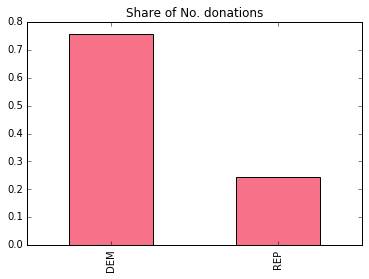

In [5]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(
    kind="bar", title="Share of No. donations")

Here we see that about 75% of all donations were given to the Democrats.

## Example 1: Simple Decision Tree Ensemble
First we will start off a simple interpretable model, a decision tree. The deeper the tree, the more complex patterns the tree can model, 

### Decision Tree Visualizer Helper Function
We will use the following function below to visualize our decision trees:

In [6]:
def visTree(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False, 
        out_file=None, 
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)  
    return Image(graph.create_png())

### Data Preparation

#### Separate target variables and features

In [7]:
X = df.drop('cand_pty_affiliation',axis=1)
y = 1*(df['cand_pty_affiliation'] == 'REP')

#### Hot-encode categorical features
Use the `sparse` argument since the dataset is quite large. This will return the results are a sparse dataframe. A sparse dataframe has the same functionality as a regular dataframe but takes up much less memory.

In [8]:
X = pd.get_dummies(X, sparse=True)

#### Split dataset into testing and training sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.95, random_state=SEED)

### Decision Tree 1 (`t1`)
We will train our first tree with a max depth of 1. 

Decision tree ROC-AUC score: 0.672


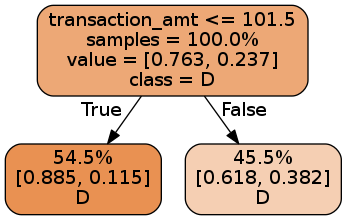

In [10]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)

t1.fit(X_train,y_train)

p = t1.predict_proba(X_test)[:,1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
visTree(t1, X_train.columns)

Each leaf shows their share of the training samples, the class distribution within their share, and the class label prediction. 

This tree decides if the size of the contribuution (`transaction_amt`) is greater than 101.5, but it makes the same prediction regardless of the outcome (`Democratic`). This is not surprising as about 75% of the donations were for Democrats. 

### Decision Tree 2 (`t2`)
We will train our second tree with a max depth of 3. 

Decision tree ROC-AUC score: 0.751


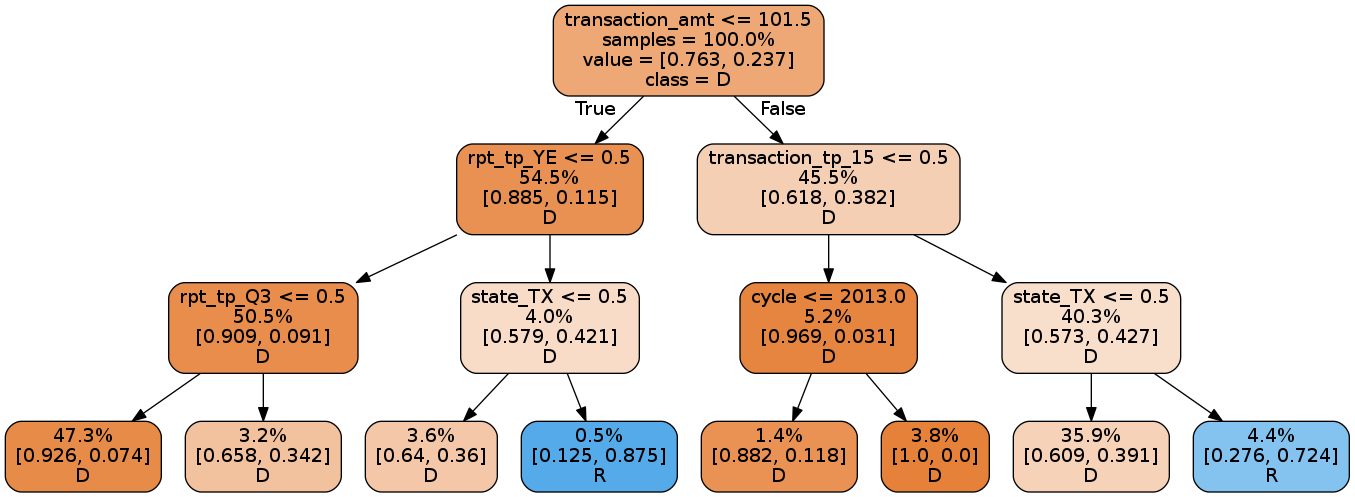

In [11]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)

t2.fit(X_train,y_train)

p = t2.predict_proba(X_test)[:,1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
visTree(t2, X_train.columns)

In this tree, we see that only 5% of the total donations go to Republicans (blue nodes). This is much less than the 25% they are supposed to get. The tree also uses some dubious splitting rules, and 47.3% of all observations ended up in the left-most leaf, and 35.9% ended up the second right-most leaf. Most of the leaves are irrelevant. Making the model deeper would just cause the model to overfit.

### Decision Tree 3 (`t3`)
With a fixed depth, a decision tree can be made more complex by increasing the 'width', e.g., creating several decision trees and combining them. The simplest way to do this is to remove features that appear higher in a tree (in our case, `transaction_amt` is the first splitting feature).

Here, we will remove `transaction_amt` from both X_train, and X_test, and train our third tree with a max depth of 3 on this slim dataset.

#### Drop `transaction_amt` from `X_train`/`X_test`

In [12]:
columns_to_drop = ['transaction_amt']

X_train_slim = X_train.drop(columns_to_drop, axis=1)
X_test_slim = X_test.drop(columns_to_drop, axis=1)

#### Train/Evaluate Tree

Decision tree ROC-AUC score: 0.740


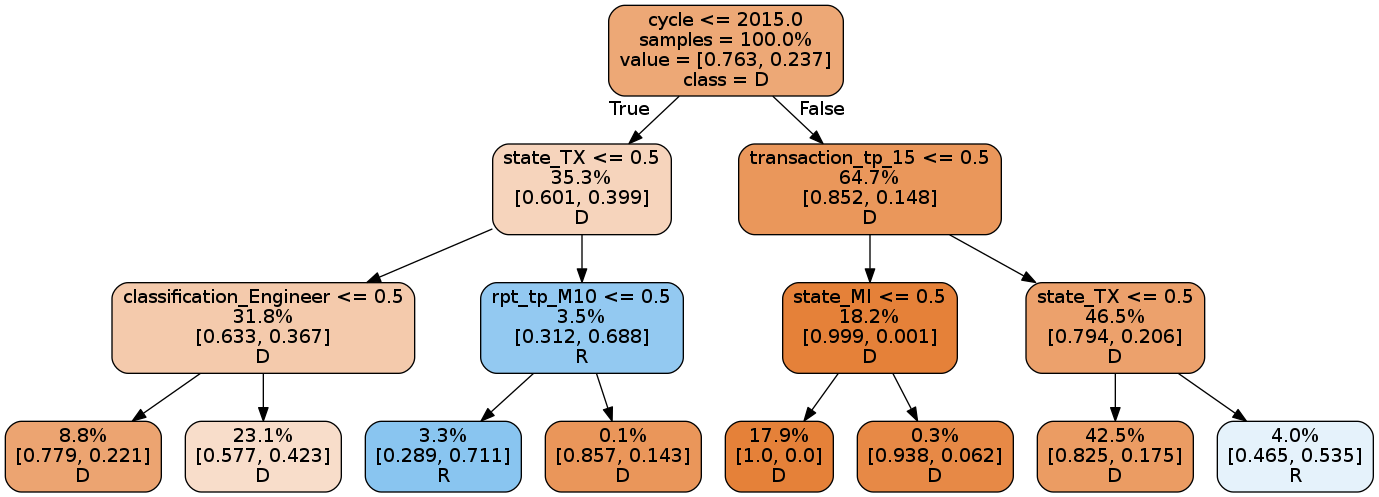

In [13]:
t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)

t3.fit(X_train_slim,y_train)

p = t3.predict_proba(X_test_slim)[:,1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
visTree(t3, X_train_slim.columns)

This tree has a similar ROC_AUC score to the previous tree, and the share of Republican donations has increased to 7.3% (3.3 + 4). Also, in contrast to the first tree, this tree is more focused on the residency of the candidate instead of the transaction itself. 

We now have 2 models that by themselves have similar predictive power, but operating differently. Because of this, they would likely have different prediction errors, and we can average this error out with an ensemble technique.

### Forest: Ensemble of `t2` and `t3`
A random forest is an ensemble technique of decision trees. Let's see if we can create one with our two final trees:

#### Check error correlation
Highly correlated errors make poor ensembles:

In [14]:
p2 = t2.predict_proba(X_test)[:,1]
p3 = t3.predict_proba(X_test_slim)[:,1]

pd.DataFrame({
        'full_data': p2,
        'red_data': p3
    }).corr()

,full_data,red_data
full_data,1.000000,0.669128
red_data,0.669128,1.000000


There is some correlation but they aren't highly correlated. There is a enough prediction variance to exploit.

#### Ensemble 1: Hard Voting Classifier
Our first ensemble simply averages the two models predictions:

In [15]:
p = np.mean([p2,p3], axis=0)

print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Average of decision tree ROC-AUC score: 0.783


As expected, the ensemble technique performed better than both individual models.

### Random Forest

If we had even more diverse trees, we could potentially build an ensemble technique that performs even better. 

*How do we choose which features to exclude for building decision trees?*

The quick approach is randomly selecting a subset of features, and fitting a decision tree on the each subset and average the predictions of all the decision trees. This process is called **bootstrapped averages**, and in the context of the decision trees, the resultant model is called a **random forest**.

Let's build a random forest using the `RandomForestClassifier` library in the `sklearn` library. Let's build an ensemble of 10 decision trees, each with a max depth of 3.

In [16]:
# Construct random forest
rf =  RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)

# Train forest
rf.fit(X_train,y_train)

# Get predictions
p = rf.predict_proba(X_test)[:,1]

print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Average of decision tree ROC-AUC score: 0.844


As expected, the random forest model yielded a significant improvement upon our previous models.

## Example 2: Averaged Prediction Ensemble

Let's build an ensemble of various models, we begin by benchmarking a set of `sklearn` classifiers on the dataset.

### Helper Function: Generate several `sklearn` models
To avoid repeating code, we use this helper function to generate several `sklearn` models

In [17]:
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }
    return models

### Helper Function: Train and get predictions for each `model` in `model_list`

In [18]:
def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict_proba(X_test)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P

#### Helper Function: Get ROC-AUC score for each model

In [19]:
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

### Get benchmark scores for each model

In [20]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models.
mlp-nn... done
knn... done
gbm... done
random forest... done
logistic... done
svm... done
naive bayes... done
Done.

Scoring models.
mlp-nn                    : 0.851
knn                       : 0.779
gbm                       : 0.878
random forest             : 0.844
logistic                  : 0.857
svm                       : 0.850
naive bayes               : 0.803
Done.



This is our baseline. The Gradient Boosting algorithm (GBM) does the best. Our ensemble technique should have a similar or better performance.

### Check correlation of prediction errors 
Our first action is still to ensure that prediction error is uncorrelated.

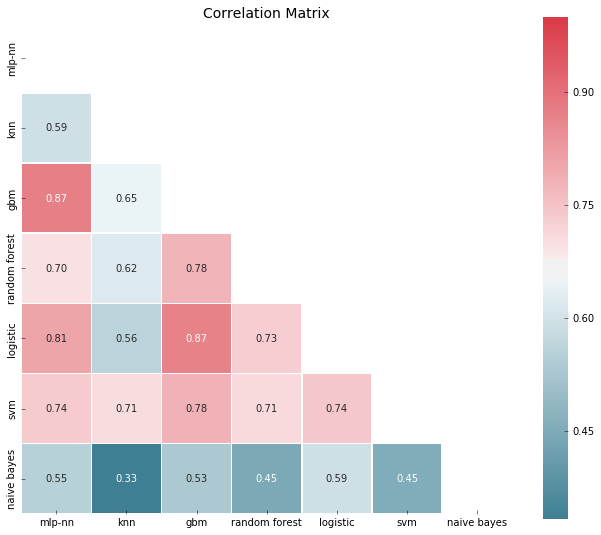

In [21]:
corrmat(P.corr(), inflate=False)

The errors are significantly correlated, which is expected of models with high accuracy, since it's typical that outliers are hard to model correctly. Yet, most correlations are in between the ranges of 50% and 80%, so there is decent room for improvement. 

### Check correlation of class prediction errors

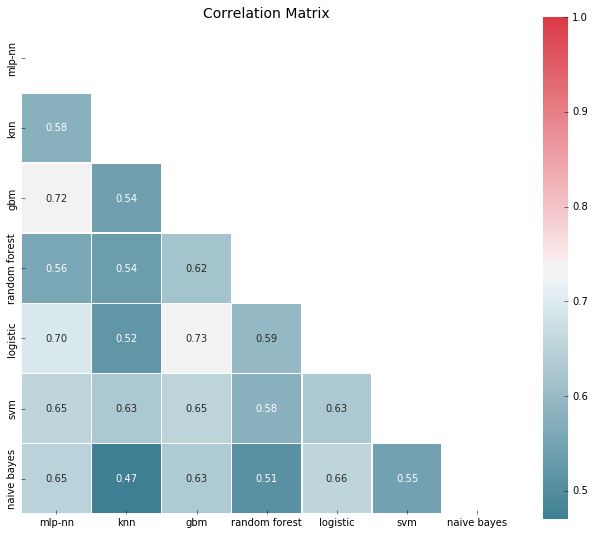

In [22]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - y_test.values).corr(), inflate=False)

The errors correlations on class predictions basis look a bit more promising.

### Create ensemble
We proceed as before and average predictions:

In [23]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.884


As expected, our ensemble outperforms the baseline. The averaging process is simple, we can start with a simple ensemble and train and add new models as we want.

### ROC Curve
We can use a ROC curve to visually understand what our ensemble technique is doing. The ROC curve shows us how an estimator trades off precision and recall. Different base learners make different trade offs. 

A non-linear meta learner, e.g, our ensemble, can adjust which model it relies on for each training training point. This means it can significantly reduce necessary sacrifices and retain high precision while increasing recall (or vice versa).

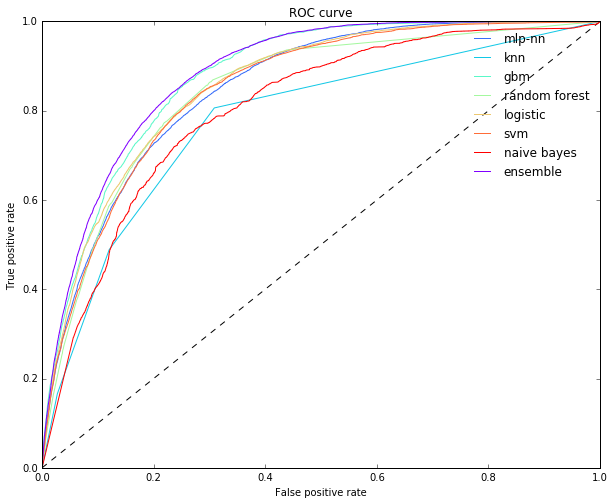

In [24]:
def plot_roc_curve(y_test, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), "ensemble")

As seen above, the ensemble is making a much smaller sacrifice in precision to increase recall (the ROC is furter in the "northwest" corner)

## Example 3: Blending Meta-Learner Ensembles
In the above ensemble technique, models with poorer performance have equal influence on the final prediction as models with good performance. This could be devastating on unbalanced datasets. E.g, with soft voting, if a model makes an extreme prediction (e.g., near 0 or 1), that prediction will have a strong pull on the ensemble's final prediction. 

### Repulication donation contribution coverage by base models
An important factor for us is whether a model is able to capture the full share of the Republican donations. We can first plot how much each model captures the republic donations:

(0, 0.27)

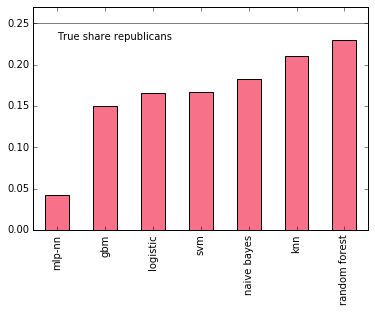

In [25]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.ylim((0,0.27))

All base models underrepresent the full share of Republican donations, but some models are considerably worse than others (e.g., mlp-nn).

### Try improving ensemble by removing the worst offender
We can try to improve our ensemble technique by removing our worst offender (Multi-layer Perceptron (MLP)):

In [26]:
include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.883


The ROC-AUC score is almost the same (0.884 vs. 0.883). We need a smarter way of prioritizing between base models. 

### Learning to combine predictions
We want to *learn* a sensible set of weights for averaging predictions by converting our ensemble into a parametric model that needs to be trained.

For a parametric ensemble model, each base model, $f_i$, has a weight parameter, $w_i\ \epsilon\ (0,1)$ that assigns a weight to that models predictions. Weighted averages require that all weights sum to 1 for $n$ models: $\sum{^n_{i=1}} w_i = 1$.

The ensemble is now defined as:

$e(x) = \sum{^n_{i=1}} w_i\ f_i(x)$.

Learning the weights is the same as fitting a linear regression on those predictions:

$e(p_1,...,p_n) = w_1\ p_1 + ... + w_n\ p_n$.

with some constraints on the weights. We also don't need to restrict ourselves to fitting just a linear model. 

We could fit a nearest neighbour model. The ensemble would take local averages based on the nearest neighbors of a given observation, empowering the ensemble to adapt to changes in model performance as the input varies.

### Implementing an ensemble

To build a parametric ensemble model, we need three things:
1. Library of base learners that generate predictions
2. Meta learner that learns how to best combine these predictions
3. Method for splitting the training data between the base learners and meta learners.

*Base learners* are the base models that take the original input to generate a set of predictions. 

If the original dataset is a matrix $X$ of shape $(n\_samples, n\_features)$, the library of base learners will output a new prediction matrix $P_{base}$ of size $(n\_samples, n\_base\_learners)$. The meta learner is trained on $P_{base}$.

For this reason, the training set $X$ **must** be handled in an appropriate way. In particular, if the base learners train and predict on $X$, the meta learner will be training on the base learner's *training error*, but at test time it will face their *test errors*.

The simplest strategy is to split the training set into two. We would train the base learners on half, and have it predict on the other half. Then use those predictions with the meta learner. This is simple and relatively fast, but the loss of information could be severe for small, or medium sized data sets causing base learners and meta learners to perform poorly.

We can also use **cross-validation** to ensure that the full dataset is covered.

#### Step 1: Define a library of base learners
*Note*: More models = longer run times.

In [27]:
base_learners = get_models()

#### Step 2: Define a meta learner
Which meta-learner to use is not obvious but popular choices are linear models, kernel-based models (SVM/KNN), and decision tree models. You could also use another ensemble as *meta learner*: in this case, you get a two-layer ensemble, akin to a feed-forward neural network.

We will use a Gradient Boosted Machine. To ensure that the GBM explores local patterns, we restrict each of the 1000 decision trees to train on a random subset of 4 base learners and 50% input data. This way, the GBM will be exposed to each base learner's strength in different neighborhoods of input space.

In [28]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)

#### Step 3: Define a procedure for generating train/test sets
We will just split the training set further into training and testing to keep things simple. This method is sometimes known as *Blending*.

In [29]:
X_train_base, X_train_pred, y_train_base, y_train_pred = train_test_split(
    X_train, y_train, test_size=0.5, random_state=SEED
)

We now have a training set for the base learners: $(X\_train\_base,y\_train\_base)$, and a testing set: $(X\_train\_pred,y\_train\_pred)$, and are ready to generate a prediction matrix for the meta learner.

#### Step 4: Train the base learners on the base training set

In [30]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")
            
train_base_learners(base_learners, X_train_base, y_train_base)                

Fitting models.
mlp-nn... done
knn... done
gbm... done
random forest... done
logistic... done
svm... done
naive bayes... done


#### Step 5: Generate base learner predictions
With the base learners fitted, we can now generate predictions for the meta learners to trai on. Note that we generate predictions for observations *not* used to train the base learner. For each observation $x_{pred}^{(i)}\ \epsilon\ X_{pred\_base}$, we generate a set of base learner predictions:

$p_{base}^{(i)} = (f_1(x_{pred}^{(i)}),...,f_n(x_{pred}^{(i)}))$

*Note*: This is more challenging to implement with cross-validation.

In [31]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P


P_base = predict_base_learners(base_learners, X_train_pred)

Generating base learner predictions.
mlp-nn... done
knn... done
gbm... done
random forest... done
logistic... done
svm... done
naive bayes... done


#### Step 6: Train the meta learner
The prediction matrix $P_{base}$ reflects test-time performance and can be used to train the meta learner:

In [32]:
meta_learner.fit(P_base, y_train_pred)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=222, subsample=0.5, verbose=0,
              warm_start=False)

That's it! We now have a fully trained ensemble that can be used to predict new data.

#### Make predictions with ensemble
 To generate a prediction for some observation $X^{(j)}$, we first feed it to the base learners to get a set of predictions we feed to the meta learner to get the ensemble's final prediction.

In [33]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

P_pred, p = ensemble_predict(base_learners, meta_learner, X_test)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Generating base learner predictions.
mlp-nn... done
knn... done
gbm... done
random forest... done
logistic... done
svm... done
naive bayes... done

Ensemble ROC-AUC score: 0.881


As expected, our ensemble technique beat the best estimator from our previous benchmark but it did not beat our simple average ensemble. This is likely due to the information loss from training with only half our data. To prevent this, we need to use a cross-validation strategy.

## Example 4: Super Learner - CV Meta-Learner Ensembles
During CV training of base learners, a copy of each base learner is fitted on $K-1$ folds, and then used to make predictions on the left out fold. This process is iterated until every fold has been used for predictions. 

K-Fold validated predictions are less noisy and are a better reflection of model performance during test time. The cost is significantly increased training time. 

Fitting an ensemble with cross-validation is often referred to as **stacking** while the ensemble itself is known as a **Super Learner**.

**How does CV work?**

We can think of it as an outer loop over our previous ensemble. The outer loop iterates over $K$ distinct test folds, with the remaining data used for training. The inner loop trains the base learners and generates predictions for the held-out data.

### Simple stacking implementation

In [34]:
def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")
    
    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

Let's go over the steps involved here. First, we fit our final base learners on all data: in contrast with our previous blend ensemble, base learners used at test time are trained on all available data. We then loop over all folds, then loop over all base learners to generate cross-validated predictions. These predictions are stacked to build the training set for the meta learner, which too sees all data.

The basic difference between blending and stacking is therefore that stacking allows both base learners and the meta learner to train on the full data set. Using 2-fold cross-validation, we can measure the difference this makes in our case:

In [35]:
# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), X_train.values, y_train.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, X_test, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Fitting final base learners...done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.889


Stacking yields a sizeable increase in performance: in fact, it gives us our best score so far. This outcome is typical for small and medium-sized data sets, where the effect of blending can be severe. As the data set size increases, blending and stacking performs similarly.

### Stacking Overview

Stacking comes with its own set of shortcomings, particularly speed. In general, we need to be aware of there important issues when it comes to implementing ensembles with cross-validation:
1. Computational complexity
2. Structural complexity (risk of information leakage)
3. Memory consumption

It's important to understand these in order to work with ensembles efficiently, so let's go through each in turn.

#### 1. Computational complexity
Suppose we want to use 10 folds for stacking. This would require training all base learners 10 times on 90% of the data, and once on all data. With 4 base learners, the ensemble would roughly be 40 times slower than using the best base learner.

But each cv-fit is independent, so we don't need to fit models sequentially. If we could fit all folds in parallel, the ensemble would only be roughly 4 times slower than the best base learner, a dramatic improvement. Ensembles are prime candidates for **parallelization**, and it is critical to leverage this capability to the greatest extent possible. Fitting all folds for all models in parallel, the time penalty for the ensemble would be negligible. To hone this point in, below is a benchmark from `ML-Ensemble` that shows the time it takes to fit an ensemble via stacking or blending either sequentially or in parallel on 4 threads.

![title](https://www.dataquest.io/blog/content/images/2018/01/scale_cpu-1.png)

Even with this moderate degree of parallelism, we can realize a sizeable reduction in computation time. But parallelization is associated with a whole host of potentially thorny issues such as race conditions, deadlocks and memory explosion.

#### 2. Structural complexity
Once we decide to use the entire training set to meta learner, we must worry about **information leakage**. This phenomena arises when we mistakenly predict samples that were used during training, for instance by mixing up our folds or using a model trained on the wrong subset. When there's information leakage in the training set of the meta learner, it will not learn to properly correct for base learner predictions errors: garbage in, garbage out. Spotting such bugs though is extremely difficult.

#### 3. Memory consumption
The final issue arises with parallelization, especially by multi-processing as is often the case in Python. In this case, each sub-process has its own memory and therefore needs to copy all data from the parent process. A naive implementation will therefore copy all data to all processes, eating up memory and wasting time on data serialization. Preventing this requires sharing data memory, which in turns easily cause data corruption.

## Example 4: Super Learner w/ `ML-Ensemble`
The upshot is that you should use a unit-tested package and focus on building your machine learning pipeline. In fact, once you've settled on a ensemble package, building ensembles becomes *really* easy: all you need to do is specify the base learners, the meta learner, and a method for training the ensemble.

Fortuntately, there are many packages available in all popular programming languages, though they come in different flavors. At the end of this post, we list some as reference. For now, let's pick one and see how a stacked ensemble does on our political contributions data set. Here, we use `ML-Ensemble` and build our previous generalized ensemble, but now using 10-fold cross-validation:

In [36]:
# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train, y_train)

# Predict the test set
p_sl = sl.predict_proba(X_test)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(y_test, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             done | 00:01:47
Processing layer-2             done | 00:00:13
Fit complete                        | 00:02:11

Predicting 2 layers
Processing layer-1             done | 00:01:41
Processing layer-2             done | 00:00:06
Predict complete                    | 00:02:02

Super Learner ROC-AUC score: 0.890


### Plot ROC Curve

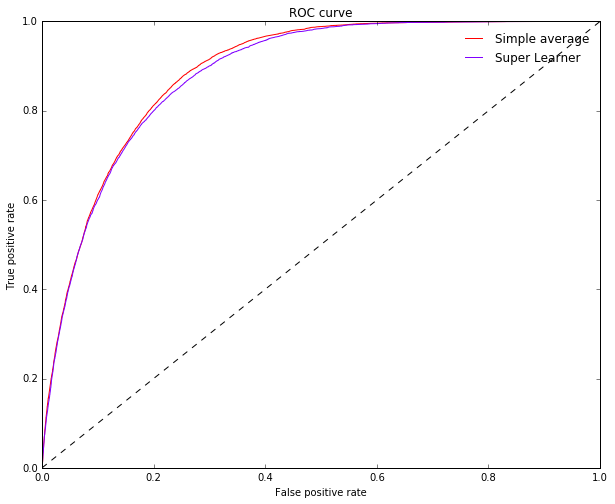

In [37]:
plot_roc_curve(y_test, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")

Inspecting the ROC-curve of the super learner against the simple average ensemble reveals how leveraging the full data enables the super learner to sacrifice less recall for a given level of precision.

## Conclusion

There are many other types of ensembles than those presented here. However the basic ingredients are always the same: a library of base learners, a meta learner, and a training procedure. By playing around with these components, various specialized forms of ensembles can be created. 

More information about ensembles can be found here: [Kaggle Ensembling Guide](https://mlwave.com/kaggle-ensembling-guide/)